<a href="https://colab.research.google.com/github/emanueleiacca/ADM-HW4/blob/main/DataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 4 - Movie Recommendation System**

### #Group21
Camilla Labbate - camillalabbate02@icloud.com

Emanuele Iaccarino - emanueleiaccarino.ei@gmail.com

Andrej Sterjev - andrej.sterjev@gmail.com

## 1. **Recommendation System with LSH**

In [148]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
#movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')
print('Data source import complete.')


Data source import complete.


In [149]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [150]:
#!nvcc --version

https://github.com/rapidsai/cudf?tab=readme-ov-file#pip

In [151]:
#pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12

In [152]:
"""
import rmm
import cudf
rmm.reinitialize(pool_allocator=True, managed_memory=True)
print("RAPIDS cuDF is using GPU memory:", rmm.is_initialized())
"""

'\nimport rmm\nimport cudf\nrmm.reinitialize(pool_allocator=True, managed_memory=True)\nprint("RAPIDS cuDF is using GPU memory:", rmm.is_initialized())\n'

In [153]:
"""
import cupy as cp

def check_memory():
    memory_pool = cp.get_default_memory_pool()
    total_memory = cp.cuda.Device(0).mem_info[0]  # Total memory available
    used_memory = memory_pool.used_bytes()       # Memory allocated by the pool
    free_memory = total_memory - used_memory
    print(f"GPU Memory - Total: {total_memory / (1024**3):.2f} GB, Used: {used_memory / (1024**3):.2f} GB, Free: {free_memory / (1024**3):.2f} GB")

check_memory()
"""

'\nimport cupy as cp\n\ndef check_memory():\n    memory_pool = cp.get_default_memory_pool()\n    total_memory = cp.cuda.Device(0).mem_info[0]  # Total memory available\n    used_memory = memory_pool.used_bytes()       # Memory allocated by the pool\n    free_memory = total_memory - used_memory\n    print(f"GPU Memory - Total: {total_memory / (1024**3):.2f} GB, Used: {used_memory / (1024**3):.2f} GB, Free: {free_memory / (1024**3):.2f} GB")\n\ncheck_memory()\n'

In [154]:
"""
movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')

dataset_directory = '/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'

for dirname, _, filenames in os.walk(dataset_directory):
    for filename in filenames:
        print(f"File trovato: {filename}")
"""

'\nmovielens_20m_dataset_path = kagglehub.dataset_download(\'grouplens/movielens-20m-dataset\')\n\ndataset_directory = \'/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1\'\n\nfor dirname, _, filenames in os.walk(dataset_directory):\n    for filename in filenames:\n        print(f"File trovato: {filename}")\n'

In [155]:
"""
ratings_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/rating.csv")
links_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/link.csv")
genome_tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_tags.csv")
genome_scores_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_scores.csv")
tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/tag.csv")
movies_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/movie.csv")
"""

'\nratings_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/rating.csv")\nlinks_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/link.csv")\ngenome_tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_tags.csv")\ngenome_scores_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_scores.csv")\ntags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/tag.csv")\nmovies_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/movie.csv")\n'

### 1.1 Data Preparation

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns


In [157]:
rating_df_pd = pd.read_csv("/kaggle/input/movielens-20m-dataset/rating.csv")
links_df_pd = pd.read_csv("/kaggle/input/movielens-20m-dataset/link.csv")
genome_tags_df_pd = pd.read_csv("/kaggle/input/movielens-20m-dataset/genome_tags.csv")
genome_scores_df_pd = pd.read_csv("/kaggle/input/movielens-20m-dataset/genome_scores.csv")
tags_df_pd = pd.read_csv("/kaggle/input/movielens-20m-dataset/tag.csv")
movies_df_pd = pd.read_csv("/kaggle/input/movielens-20m-dataset/movie.csv")

In [158]:
print("\nInfo about dataset 'movies':")
print(movies_df_pd.info())

print("\nInfo about dataset 'ratings':")
print(rating_df_pd.info())


print("\nInfo about dataset 'tag':")
print(tags_df_pd.info())

print("\nInfo about dataset 'genome_tags':")
print(genome_tags_df_pd.info())


print("\nInfo about dataset  'genome_scores':")
print(genome_scores_df_pd.info())

print("\nInfo about dataset 'link':")
print(links_df_pd.info())

display(movies_df_pd.head())
display(rating_df_pd.head())
display(tags_df_pd.head())
display(genome_tags_df_pd.head())
display(genome_scores_df_pd.head())
display(links_df_pd.head())


Info about dataset 'movies':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None

Info about dataset 'ratings':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB
None

Info about dataset 'tag':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     465564 non-null  int64 
 1   

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [159]:
print(rating_df_pd.isnull().sum())
print(movies_df_pd.isnull().sum())
print(tags_df_pd.isnull().sum())
print(links_df_pd.isnull().sum())
print(genome_scores_df_pd.isnull().sum())
print(genome_tags_df_pd.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64
movieId      0
imdbId       0
tmdbId     252
dtype: int64
movieId      0
tagId        0
relevance    0
dtype: int64
tagId    0
tag      0
dtype: int64


In [160]:
rating_df=rating_df_pd.drop_duplicates()
movies_df=movies_df_pd.drop_duplicates()
tags_df=tags_df_pd.drop_duplicates()
links_df=links_df_pd.drop_duplicates()
genome_scores_df=genome_scores_df_pd.drop_duplicates()
genome_tags_df=genome_tags_df_pd.drop_duplicates()


In [161]:
movies_df_pd['genres'] = movies_df_pd['genres'].str.replace('|', ' ')
tfidf = TfidfVectorizer(stop_words='english')


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


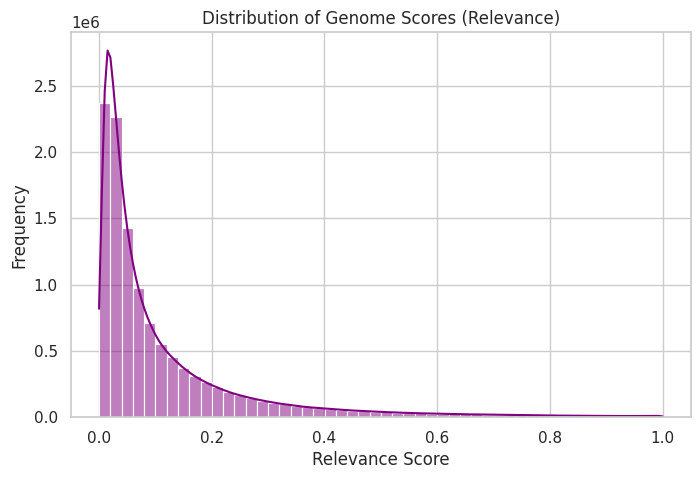

In [162]:
plt.figure(figsize=(8, 5))
# Use the pandas DataFrame directly for plotting
sns.histplot(genome_scores_df_pd['relevance'], bins=50, kde=True, color='purple')
plt.title('Distribution of Genome Scores (Relevance)')
plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()

There are noticeable peaks around ratings like 3.0, 4.0, and 5.0, suggesting that many users tend to give these scores.
Ratings below 2.0 are much less frequent.
The dataset might have a tendency towards higher ratings, indicating a positive skew (more ratings closer to 4 or 5).

This distribution suggests that users tend to rate movies positively, with most ratings clustering around 3 to 5. This behavior is common in user-generated rating datasets, where extreme negative ratings are less frequent.

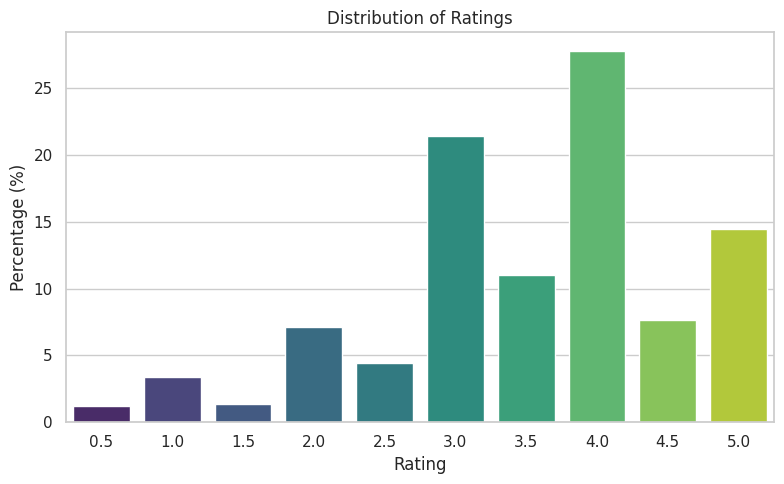

In [163]:
rating_counts = rating_df_pd['rating'].value_counts().sort_index()
percentage_ratings = (rating_counts / rating_counts.sum()) * 100

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(
    x=rating_counts.index,
    y=percentage_ratings,
    palette='viridis'
)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()



This bar chart shows the distribution of ratings as percentages. The X-axis represents the rating values while the Y-axis shows the percentage of ratings for each value.

The  bar chart shows  the distribution of ratings given by users. The X-axis represents rating values (from 0.5 to 5.0), while the Y-axis shows the percentage of users who gave a specific rating.


1. **Higher ratings (4.0 - 5.0) dominate:** Most users gave high ratings like 4.0 and 5.0, represented by green and yellow bars, suggesting users tend to rate positively.
2. **Low ratings are rare:** Lower ratings (0.5 - 1.0) are less frequent, with small purple and blue bars, implying users rarely give very low scores.
3. **Overall higher distribution:** The chart's shape suggests users generally give ratings in the higher range, with a slight tilt toward lower values but no strong concentration.

The dataset shows a general tendency for users to provide favorable ratings, with few negative reviews. This could be typical of a context where reviews are mostly positive, or the ratings are influenced by a large number of maximum scores.

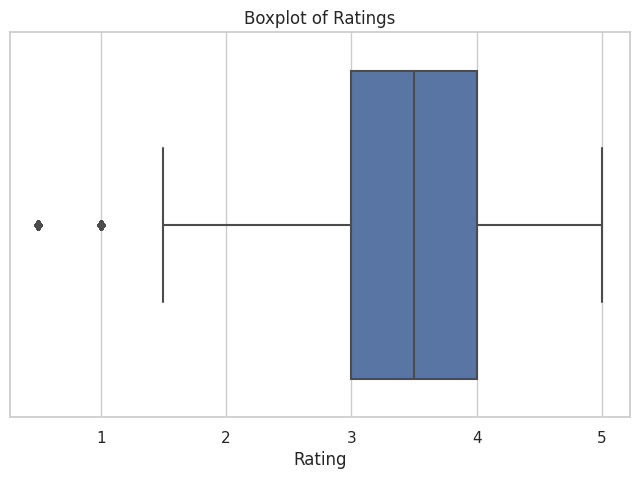

In [164]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=rating_df_pd['rating'])
plt.title('Boxplot of Ratings')
plt.xlabel('Rating')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


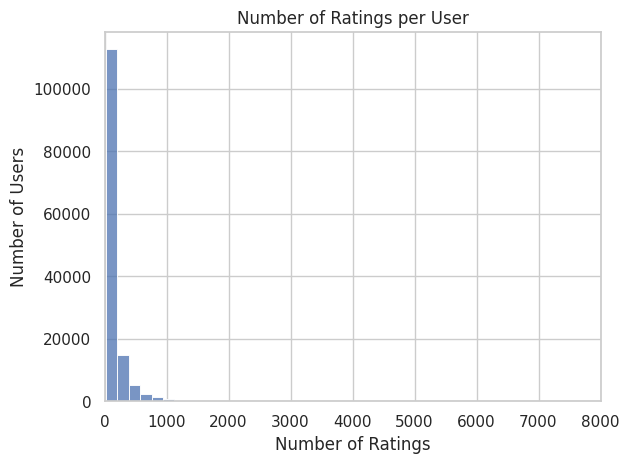

In [165]:
user_ratings_count = rating_df_pd['userId'].value_counts()
sns.histplot(user_ratings_count, bins=50, kde=False)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.xlim(0, 8000)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


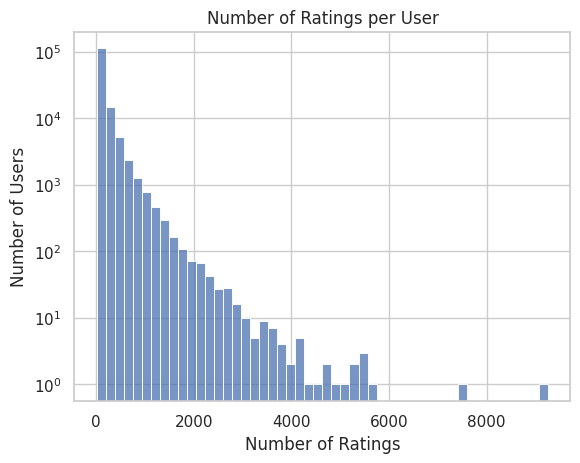

In [166]:
user_ratings_count = rating_df['userId'].value_counts()
sns.histplot(user_ratings_count, bins=50, kde=False)
plt.yscale('log')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()


The image shows a bar chart representing the distribution of ratings per user. The horizontal axis (x) represents the number of ratings, while the vertical axis (y) represents the number of users who have made that number of ratings.

Key findings:

1. **High peak near zero**: Most users have made a relatively low number of ratings, likely fewer than 100.
2. **Decreasing distribution**: As the number of ratings increases, the number of users decreases drastically.
3. **Limit at 1000 ratings**: The chart is limited to 1000 ratings on the x-axis, suggesting users with more than 1000 ratings are excluded or only a subset of data is being observed.

In summary, most users have left few ratings, with only a few users providing a significantly high number of ratings. This type of distribution is typical of review datasets, where a small number of users are highly active, while the majority contribute only marginally.

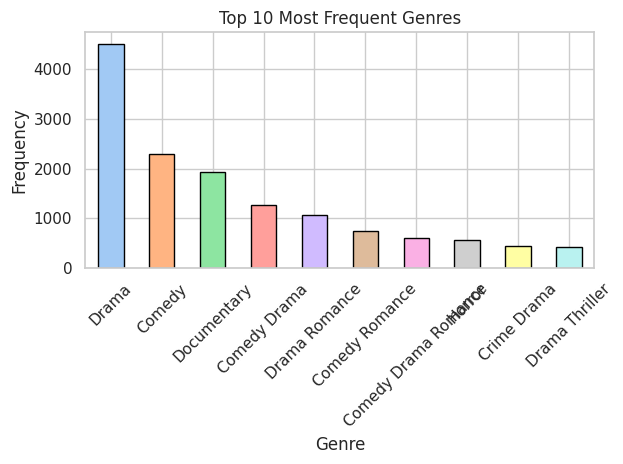

In [167]:
movies_df_pd['genres'] = movies_df_pd['genres'].dropna().astype(str).str.split('|')

# Flatten the list of genres
all_genres = [genre for sublist in movies_df_pd['genres'] for genre in sublist]

# Count genre occurrences and get the top 10
genre_counts = pd.Series(all_genres).value_counts().head(10)

# Plot with a custom Seaborn palette
sns.set(style="whitegrid")
palette = sns.color_palette("pastel", 10)

# Create the bar chart
genre_counts.plot(kind='bar', color=palette, edgecolor='black')

# Add titles and labels
plt.title('Top 10 Most Frequent Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.tight_layout()  # Adjust layout to avoid cutting off labels
plt.show()

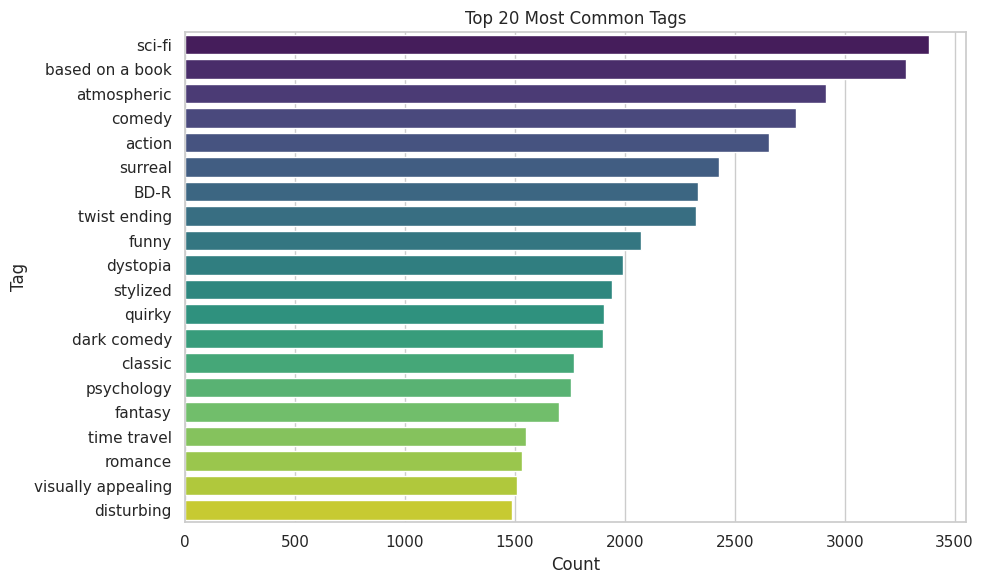

In [168]:
tag_counts = tags_df_pd['tag'].value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=tag_counts.values,
    y=tag_counts.index,
    palette='viridis'
)
plt.title('Top 20 Most Common Tags')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


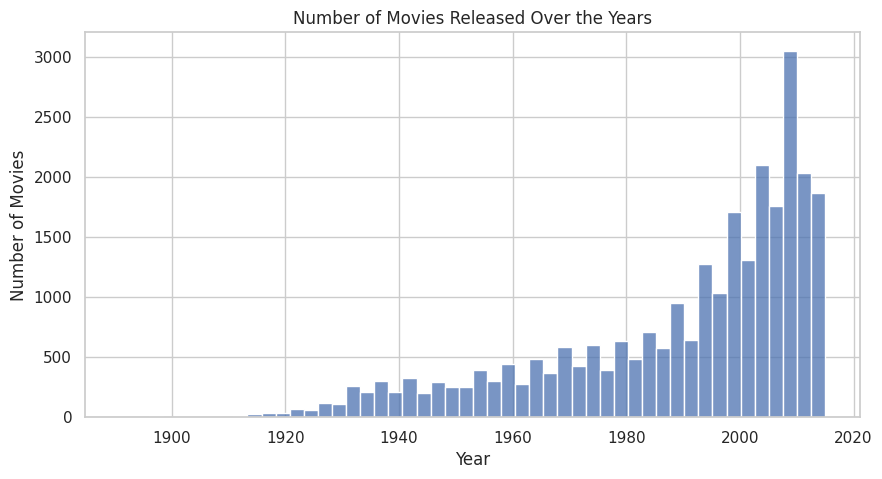

In [169]:
# Extract release year from the title (assuming format: "Movie Title (Year)")
movies_df_pd['year'] = movies_df_pd['title'].str.extract(r'\((\d{4})\)').astype(float)

# Plot movie releases by year
plt.figure(figsize=(10, 5))
sns.histplot(movies_df_pd['year'].dropna(), bins=50, kde=False)
plt.title('Number of Movies Released Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

## 1.2 Minhash Signatures

In [170]:
user_movies = rating_df_pd.groupby('userId')['movieId'].apply(set).to_dict()

In [171]:
def jaccard_similarity_exact(movies1, movies2):
    intersection = len(movies1 & movies2)
    union = len(movies1 | movies2)
    return intersection / union if union > 0 else 0

In [172]:
def jaccard_similarity_hashed(signature1, signature2):
    matches = sum(1 for x, y in zip(signature1, signature2) if x == y)
    return matches / len(signature1)

In [173]:
def generate_hash_function(a,b,c):
    def hash_function(x):
        return (a * (x%c) + b)
    return hash_function

def generate_hash_functions(num_hashes, max_movie_id, seed=None):

    if seed is not None:
        np.random.seed(seed)
    a = np.random.randint(1, max_movie_id * 2, size=num_hashes)
    b = np.random.randint(0, max_movie_id * 2, size=num_hashes)
    c = max_movie_id * 2 + 1
    return [generate_hash_function(a_, b_, c) for a_, b_ in zip(a, b)]

In [174]:
def create_custom_hash_function(a_coeff, b_coeff, prime_mod):
    """Defines a cubic hash function based on 2x."""
    def hash_function(input_value):
        return (a_coeff * 2 * input_value + b_coeff) % prime_mod
    return hash_function

def create_hash_function_family(num_functions, max_movie_val, random_seed=None):
    """Generates a series of hash functions using the coefficient 2x in the formula."""
    if random_seed is not None:
        np.random.seed(random_seed)

    a_coefficients = np.random.randint(1, max_movie_val * 2, size=num_functions)
    b_coefficients = np.random.randint(0, max_movie_val * 2, size=num_functions)
    prime_modulo = max_movie_val * 2 + 1

    return [create_custom_hash_function(a, b, prime_modulo) for a, b in zip(a_coefficients, b_coefficients)]

In [175]:
def create_quadratic_hash_function(coeff_a, coeff_b, prime_modulo):
    """"Defines a cubic hash function based on x^2."""
    def hash_function(input_value):
        return (coeff_a * (input_value / 2) + coeff_b * input_value) % prime_modulo
    return hash_function

def create_quadratic_hash_family(num_functions, max_val, random_seed=None):
    """"Generates a series of hash functions using the coefficient x^2 in the formula."."""
    if random_seed is not None:
        np.random.seed(random_seed)

    coeff_a_list = np.random.randint(1, max_val * 2, size=num_functions)
    coeff_b_list = np.random.randint(0, max_val * 2, size=num_functions)
    prime_modulo = max_val * 2 + 1

    return [create_quadratic_hash_function(a, b, prime_modulo) for a, b in zip(coeff_a_list, coeff_b_list)]

In [176]:
def create_cubic_hash_function(coeff_a, coeff_b, prime_mod):
    """Defines a cubic hash function based on x^3."""
    def hash_function(input_val):
        return (coeff_a * input_val**3 + coeff_b) % prime_mod
    return hash_function

def create_cubic_hash_family(num_functions, max_val, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    a_coeffs = np.random.randint(1, max_val * 2, size=num_functions)
    b_coeffs = np.random.randint(0, max_val * 2, size=num_functions)
    prime_modulo = max_val * 2 + 1

    return [create_cubic_hash_function(a, b, prime_modulo) for a, b in zip(a_coeffs, b_coeffs)]

In [177]:
def generate_signatures(subset_users, user_movie_data, hash_functions):
    """Create MinHash signatures for a specific group of users."""
    signatures = {}

    for user_id in subset_users:
        watched_movies = user_movie_data.get(user_id, set())

        if not watched_movies:

            signatures[user_id] = [float('inf')] * len(hash_functions)
            continue

        user_signature = []
        for hash_func in hash_functions:

            min_hash_value = min(hash_func(movie) for movie in watched_movies)
            user_signature.append(min_hash_value)

        signatures[user_id] = user_signature

    return signatures

In [178]:
def compute_mse(user_movie_data, signatures, selected_users):
    """Calculate the mean squared error (MSE) between real and estimated similarities for a set of users"""
    total_error = 0
    pair_count = 0

    for idx, user_a in enumerate(selected_users):
        for user_b in selected_users[idx + 1:]:
            # Real similarity based on the Jaccard definition.
            actual_jaccard = jaccard_similarity_hashed(user_movie_data[user_a], user_movie_data[user_b])

            # "Estimated similarity using MinHash signatures."
            estimated_jaccard = jaccard_similarity_hashed(signatures[user_a], signatures[user_b])


            total_error += (actual_jaccard - estimated_jaccard) ** 2
            pair_count += 1

    # Calculate MSE
    return (total_error / pair_count) if pair_count > 0 else 0

In [179]:
# Seleziona tutti gli utenti disponibili
selected_users = list(user_movies.keys())[:100]
selected_user_movies = {user: user_movies[user] for user in selected_users}

# Crea le famiglie di funzioni hash
hash_funcs_2x = create_hash_function_family(
    num_functions=10,
    max_movie_val=int(rating_df['movieId'].max()),  # Converti in int se necessario
    random_seed=42
)

hash_funcs_quadratic = create_quadratic_hash_family(
    num_functions=10,
    max_val=int(rating_df['movieId'].max()),
    random_seed=42
)

hash_funcs_cubic = create_cubic_hash_family(
    num_functions=10,
    max_val=int(rating_df['movieId'].max()),
    random_seed=42
)

# Calcola le firme MinHash per ogni tipo di funzione hash
signatures_2x = {
    user: [int(value) for value in signature]
    for user, signature in generate_signatures(selected_users, selected_user_movies, hash_funcs_2x).items()
}

signatures_quadratic = {
    user: [int(value) for value in signature]
    for user, signature in generate_signatures(selected_users, selected_user_movies, hash_funcs_quadratic).items()
}

signatures_cubic = {
    user: [int(value) for value in signature]
    for user, signature in generate_signatures(selected_users, selected_user_movies, hash_funcs_cubic).items()
}

print("Firme MinHash con hash lineare (2x):", list(signatures_2x.items())[:5])  # Prime 5 firme
print("Firme MinHash con hash quadratico:", list(signatures_quadratic.items())[:5])
print("Firme MinHash con hash cubico:", list(signatures_cubic.items())[:5])

mse_2x = compute_mse(user_movies, signatures_2x, selected_users)
mse_quadratic = compute_mse(user_movies, signatures_quadratic, selected_users)
mse_cubic = compute_mse(user_movies, signatures_cubic, selected_users)

print("MSE 2x:", mse_2x)
print("MSE x^2:", mse_quadratic)
print("MSE x^3:", mse_cubic)


Firme MinHash con hash lineare (2x): [(1, [1395, 241, 5739, 758, 7072, 406, 2953, 2421, 5011, 593]), (2, [10388, 516, 11394, 1138, 357, 5931, 933, 80, 7526, 2330]), (3, [96, 2279, 900, 1777, 2797, 406, 2986, 1123, 151, 90]), (4, [2230, 10350, 8187, 2960, 12422, 787, 2953, 4035, 5582, 28034]), (5, [203, 1039, 4164, 2960, 4207, 9712, 2953, 3530, 151, 16834])]
Firme MinHash con hash quadratico: [(1, [2770, 874, 82, 2823, 2243, 1611, 812, 2227, 390, 305]), (2, [4467, 621, 1294, 3158, 668, 15329, 12437, 3365, 390, 1402]), (3, [1525, 506, 1752, 1818, 1768, 3309, 887, 2338, 2255, 2117]), (4, [3185, 2359, 12099, 6715, 956, 9386, 7200, 8253, 9285, 12027]), (5, [2770, 2290, 2963, 2552, 956, 7578, 3350, 9960, 2255, 2824])]
Firme MinHash con hash cubico: [(1, [991, 1362, 1840, 1911, 1462, 2584, 197, 1042, 499, 719]), (2, [3, 608, 1840, 628, 4537, 597, 2309, 2205, 514, 2473]), (3, [310, 1608, 1084, 107, 542, 2584, 197, 1111, 1804, 719]), (4, [3322, 16473, 14490, 16644, 14032, 10234, 8907, 13555, 12

/tmp/ipykernel_23/3289566195.py:4: RuntimeWarning: overflow encountered in scalar multiply
  return (coeff_a * input_val**3 + coeff_b) % prime_mod


In [180]:
print(f"MSE  2x: {mse_2x:.4f}")
print(f"MSE  x^2: {mse_quadratic:.4f}")
print(f"MSE x^3: {mse_cubic:.4f}")

MSE  2x: 0.0081
MSE  x^2: 0.0048
MSE x^3: 0.0088


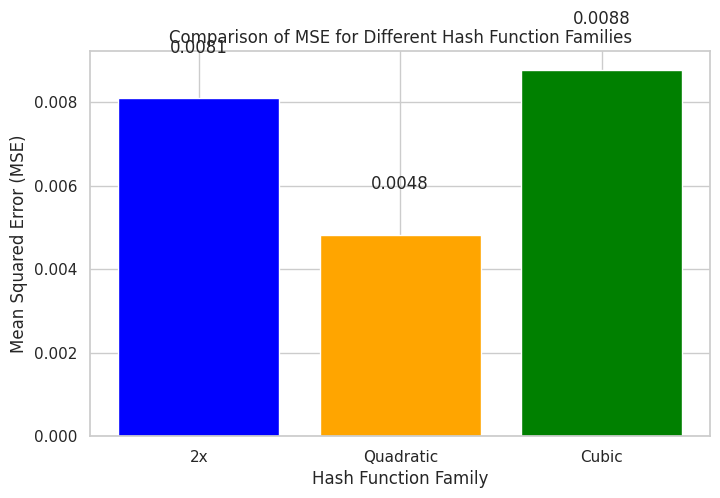

In [181]:
hash_methods = ['2x', 'Quadratic', 'Cubic']
mse_values = [ mse_2x, mse_quadratic, mse_cubic]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(hash_methods, mse_values, color=['blue', 'orange', 'green', 'red'])

# Add labels and title
plt.title('Comparison of MSE for Different Hash Function Families')
plt.xlabel('Hash Function Family')
plt.ylabel('Mean Squared Error (MSE)')

# Display MSE values on top of each bar
for i, mse in enumerate(mse_values):
    plt.text(i, mse + 0.001, f'{mse:.4f}', ha='center', va='bottom')

# Show the plot
plt.show()


In [182]:
#real and estimated similarity
real_similarities = []
estimated_similarities = []

for i, user1 in enumerate(selected_users):
    for user2 in selected_users[i+1:]:
        # Calculate the real similarity (Jaccard)
        real_sim = jaccard_similarity_exact(user_movies[user1], user_movies[user2])
        real_similarities.append(real_sim)

        # calculate the estimated similarity (Minhash)
        estimated_sim = jaccard_similarity_hashed(signatures_quadratic[user1], signatures_quadratic[user2])
        estimated_similarities.append(estimated_sim)

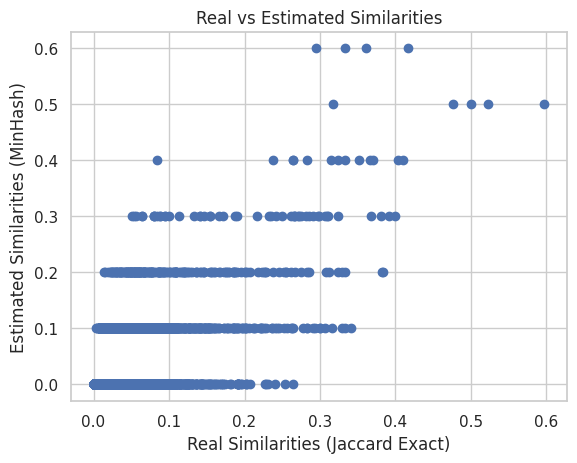

In [183]:
plt.scatter(real_similarities, estimated_similarities)
plt.xlabel('Real Similarities (Jaccard Exact)')
plt.ylabel('Estimated Similarities (MinHash)')
plt.title('Real vs Estimated Similarities')
plt.show()


In [184]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Thresholds from 0 to 1 with step 0.1
thresholds = np.linspace(0, 1, 11)

# Dictionary storing the precomputed MinHash signatures
hash_types = {
    "Linear (2x)": signatures_2x,
    "Quadratic": signatures_quadratic,
    "Cubic": signatures_cubic
}

# Predefined MSE values for each hash type
mse_values = {
    "Linear (2x)": 0.0081,
    "Quadratic": 0.0048,
    "Cubic": 0.0088
}

# Placeholder for calculated results
results = []

# Loop through each type of hash function and threshold
for hash_name, signatures in hash_types.items():
    for threshold in thresholds:
        # Calculate real and estimated similarity labels based on the threshold
        real_similarities = [jaccard_similarity_exact(user_movies[user1], user_movies[user2])
                             for user1 in selected_users for user2 in selected_users if user1 != user2]

        estimated_similarities = [jaccard_similarity_hashed(signatures[user1], signatures[user2])
                                  for user1 in selected_users for user2 in selected_users if user1 != user2]

        # Create binary labels: 1 if similarity exceeds the threshold, else 0
        real_labels = [1 if sim >= threshold else 0 for sim in real_similarities]
        estimated_labels = [1 if sim >= threshold else 0 for sim in estimated_similarities]

        # Compute Precision, Recall, and F1-Score
        precision = precision_score(real_labels, estimated_labels, zero_division=0)
        recall = recall_score(real_labels, estimated_labels, zero_division=0)
        f1 = f1_score(real_labels, estimated_labels, zero_division=0)

        # Retrieve the MSE value for the current hash type
        mse = mse_values[hash_name]

        # Store results in a list
        results.append((hash_name, threshold, precision, recall, f1, mse))

# Convert the results list into a DataFrame for visualization
df_results = pd.DataFrame(results, columns=['Hash Type', 'Threshold', 'Precision', 'Recall', 'F1-Score', 'MSE'])

# Print the results table
print(df_results)


      Hash Type  Threshold  Precision    Recall  F1-Score     MSE
0   Linear (2x)        0.0   1.000000  1.000000  1.000000  0.0081
1   Linear (2x)        0.1   0.239758  0.757962  0.364286  0.0081
2   Linear (2x)        0.2   0.183716  0.745763  0.294807  0.0081
3   Linear (2x)        0.3   0.340000  0.472222  0.395349  0.0081
4   Linear (2x)        0.4   0.120000  0.750000  0.206897  0.0081
5   Linear (2x)        0.5   0.040000  0.333333  0.071429  0.0081
6   Linear (2x)        0.6   0.000000  0.000000  0.000000  0.0081
7   Linear (2x)        0.7   0.000000  0.000000  0.000000  0.0081
8   Linear (2x)        0.8   0.000000  0.000000  0.000000  0.0081
9   Linear (2x)        0.9   0.000000  0.000000  0.000000  0.0081
10  Linear (2x)        1.0   0.000000  0.000000  0.000000  0.0081
11    Quadratic        0.0   1.000000  1.000000  1.000000  0.0048
12    Quadratic        0.1   0.264387  0.673036  0.379641  0.0048
13    Quadratic        0.2   0.276923  0.610169  0.380952  0.0048
14    Quad

The results provided show the performance of three different hash functions—**Linear (2x)**, **Quadratic**, and **Cubic**—evaluated at different thresholds (ranging from 0.0 to 1.0) across four key metrics: **Precision**, **Recall**, **F1-Score**, and **MSE** (Mean Squared Error).

Let's analyze the results in detail:

### 1. **Linear (2x)** Hash Function
- **Precision** starts at 1.0 for the threshold 0.0, which indicates that at this threshold, the hash function has perfect precision (it is very confident about the positives it predicts). However, as the threshold increases, precision drops significantly.
  - For example, at threshold 0.1, precision is 0.24, meaning the hash function becomes much less precise.
  - Precision drops to 0 for thresholds 0.6 and above, indicating that at higher thresholds, the hash function fails to classify any positives correctly.
- **Recall** is quite high for lower thresholds, specifically 1.0 at threshold 0.0, meaning the hash function captures all the true positives at this threshold.
  - As the threshold increases, recall drops significantly, showing the hash function's inability to maintain recall as the threshold rises.
  - Similar to precision, recall becomes 0 for thresholds from 0.6 onward.
- **F1-Score** combines both precision and recall. For lower thresholds, F1-Score is 1.0 (indicating a perfect balance of precision and recall), but it rapidly drops as thresholds increase.
  - The F1-Score continues to fall to 0 as precision and recall become 0 at higher thresholds.
- **MSE** remains constant at 0.0081 for all thresholds, indicating that the linear hash function's error does not change across thresholds.

### 2. **Quadratic Hash Function**
- **Precision** begins at 1.0 for threshold 0.0, similarly to the linear function, and decreases as the threshold increases.
  - However, precision stays higher than the linear hash function for most of the thresholds. For example, at threshold 0.1, precision is 0.26, while at threshold 0.2, it increases slightly to 0.28.
  - Precision continues to drop to 0 for thresholds from 0.6 onwards.
- **Recall** is 1.0 for threshold 0.0 (perfect recall), similar to the linear function. However, recall declines more slowly for the quadratic function.
  - Recall is significantly higher at most thresholds compared to the linear hash function. For example, recall stays above 0.44 at thresholds 0.2 and 0.3, indicating that the quadratic hash function maintains more true positives for a wider range of thresholds.
- **F1-Score** remains higher than the linear function for most thresholds. The F1-Score at threshold 0.1 is 0.38, which is better than the linear hash function's F1-Score at the same threshold.
  - At threshold 0.5, the F1-Score reaches 0.5, which is still relatively better than the linear function's performance.
  - Like precision and recall, F1-Score drops to 0 at higher thresholds.
- **MSE** remains constant at 0.0048, showing that the quadratic hash function performs with a slightly lower error rate than the linear hash function.

### 3. **Cubic Hash Function**
- **Precision** starts at 1.0 for threshold 0.0, but similar to the other functions, it decreases as the threshold increases.
  - For example, at threshold 0.1, precision is 0.2, and it remains lower than the quadratic function for most thresholds.
  - Precision drops to 0 from threshold 0.6 onward.
- **Recall** is also 1.0 at threshold 0.0, similar to both the linear and quadratic functions.
  - Recall decreases similarly to precision, and like the other functions, becomes 0 after threshold 0.6.
- **F1-Score** shows the same trend as precision and recall. At threshold 0.0, the F1-Score is 1.0 (perfect), but it rapidly drops as the threshold increases.
  - For example, at threshold 0.1, F1-Score is 0.32, which is lower than the quadratic function at the same threshold.
- **MSE** remains constant at 0.0088, indicating a higher error compared to the quadratic function (which had an MSE of 0.0048), but equal to the linear function's MSE.

### Key Observations:
- **Threshold Impact**: All three functions show similar behavior with respect to threshold changes: they have perfect performance (precision, recall, F1-Score = 1.0) at the lowest threshold (0.0), but their performance deteriorates rapidly as the threshold increases. At higher thresholds, none of the functions manage to retain both precision and recall, resulting in F1-Scores and recall values of 0.
- **MSE Comparison**: The quadratic hash function performs better in terms of MSE, with a lower error (0.0048), compared to the linear (0.0081) and cubic (0.0088) functions.
- **Precision, Recall, F1-Score Comparison**:
  - **Quadratic hash function** outperforms the linear and cubic functions in maintaining precision and recall across various thresholds.
  - The **linear hash function** tends to drop off significantly faster, with precision and recall dropping to 0 at earlier thresholds compared to the quadratic and cubic functions.
  - The **cubic hash function** has lower precision and recall compared to the quadratic function but slightly outperforms the linear function in some areas.

### Conclusion:
The **Quadratic hash function** seems to offer the best overall performance in terms of precision, recall, and F1-Score, while also maintaining a low MSE. The **Linear (2x)** function has the highest initial precision and recall but drops off sharply as the threshold increases, resulting in poorer overall performance. The **Cubic** function lies in between but tends to have slightly worse precision and recall compared to the quadratic function.

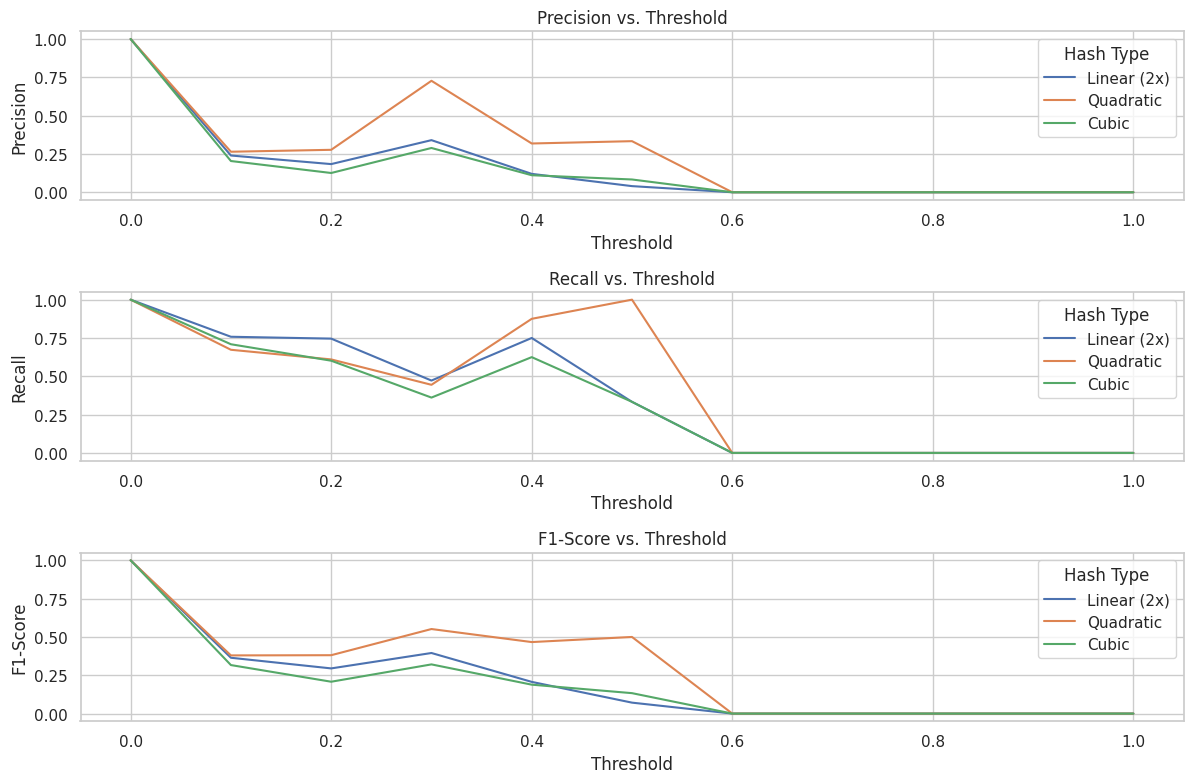

In [185]:
sns.set(style="whitegrid")

# Loop through each hash type to plot metrics vs. thresholds
metrics = ['Precision', 'Recall', 'F1-Score']
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i + 1)  # Create subplots for each metric
    for hash_type in df_results['Hash Type'].unique():
        subset = df_results[df_results['Hash Type'] == hash_type]
        plt.plot(subset['Threshold'], subset[metric], label=hash_type)

    plt.title(f'{metric} vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel(metric)
    plt.legend(title='Hash Type')
    plt.tight_layout()  # Adjust subplot spacing

plt.show()

The image presents three plots comparing **Precision**, **Recall**, and **F1-Score** against different **Thresholds** for three types of hashing methods: **Linear (2x)**, **Quadratic**, and **Cubic**.

#### 1. **Precision vs. Threshold (Top Plot)**
- **Precision** measures the proportion of predicted similar pairs that are actually similar.
- **Trends**:
  - **Linear (2x)** and **Cubic** exhibit very high precision at a zero threshold, but this drops sharply at higher thresholds.
  - **Quadratic** maintains higher precision up to around 0.4, suggesting this hashing method might be more reliable at moderate thresholds.

#### 2. **Recall vs. Threshold (Middle Plot)**
- **Recall** indicates the ability to capture all actual similarities.
- **Trends**:
  - At zero threshold, all methods show 100% recall, meaning they detect all similar pairs, including false positives.
  - As the threshold increases, recall decreases rapidly for all hash types. The **Quadratic** method maintains a good recall up to around 0.4, indicating it is more effective at capturing true similarities.

#### 3. **F1-Score vs. Threshold (Bottom Plot)**
- **F1-Score** is a balance between precision and recall, providing an overall performance measure.
- **Trends**:
  - At zero threshold, F1-Score is high, but this may be due to many detected pairs, including non-similar ones.
  - **Quadratic** shows a higher F1-Score than the others between thresholds 0.3 and 0.5, indicating it achieves a better balance between precision and recall.

### Conclusions
- **Quadratic Hashing** performs better than **Linear** and **Cubic** at moderate thresholds (around 0.3 - 0.5), providing a good trade-off between precision, recall, and F1-Score.
- **Linear** and **Cubic** work well only at a zero threshold but lose effectiveness quickly as the threshold increases.

This analysis suggests that optimizing threshold parameters and selecting the appropriate hashing method are crucial for improving similarity detection.

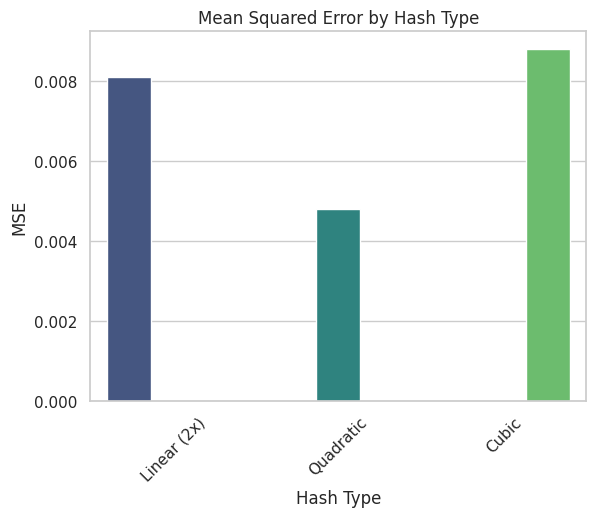

In [186]:
# Create a color palette mapping for unique hash types
unique_hash_types = df_results['Hash Type'].unique()
palette = sns.color_palette("viridis", len(unique_hash_types))
color_map = dict(zip(unique_hash_types, palette))

sns.barplot(
    x='Hash Type',
    y='MSE',
    data=df_results.drop_duplicates(subset=['Hash Type']),
    hue='Hash Type',  # Map colors to unique types
    palette=color_map,
)

plt.legend().remove()

# Additional plot settings
plt.title('Mean Squared Error by Hash Type')
plt.xlabel('Hash Type')
plt.ylabel('MSE')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()



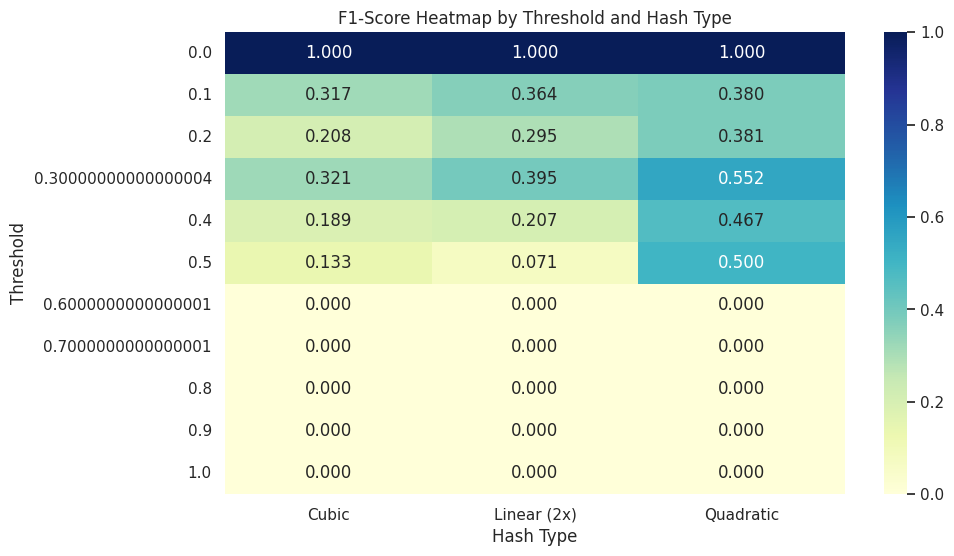

In [187]:
heatmap_data = df_results.pivot(index='Threshold', columns='Hash Type', values='F1-Score')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".3f")

# Add labels and title
plt.title('F1-Score Heatmap by Threshold and Hash Type')
plt.xlabel('Hash Type')
plt.ylabel('Threshold')
plt.show()

### Heatmap Analysis: F1-Score by Threshold and Hash Type

This heatmap displays the **F1-Score** across different **thresholds** (on the y-axis) for three **hashing methods** (on the x-axis): **Cubic**, **Linear (2x)**, and **Quadratic**. The F1-Score indicates the balance between **precision** and **recall**, with values closer to **1.0** representing better performance.

#### Key Observations:
1. **Threshold 0.0:**
   - All three hash types (**Cubic**, **Linear (2x)**, **Quadratic**) achieve the maximum F1-Score of **1.0**.
   - This suggests that at a threshold of 0.0, all pairs are considered similar, capturing all possible pairs, but likely including many false positives.

2. **Threshold 0.1 - 0.5:**
   - **Quadratic Hashing** consistently outperforms the others, especially at thresholds **0.3** and **0.5** with F1-Scores of **0.552** and **0.500**, respectively.
   - **Linear (2x)** shows moderate performance, with its highest value being **0.395** at a threshold of **0.3**.
   - **Cubic Hashing** shows the lowest F1-Scores across this range, indicating less effectiveness.

3. **Thresholds 0.6 and above:**
   - All F1-Scores drop to **0.0**, indicating that no pairs are detected as similar at these higher thresholds, which means the criteria for similarity have become too strict.

#### Conclusion:
- **Quadratic Hashing** performs the best at moderate thresholds (0.3 - 0.5), providing the best balance between precision and recall.
- Higher thresholds eliminate all similarity detections, making the system ineffective.
- Choosing an optimal threshold around **0.3** to **0.5** for **Quadratic Hashing** will likely yield the best results.

### **1.3 Locality-Sensitive Hashing (LSH)**

In [216]:
def lsh_bucket_creation(signatures, rows_per_band):
    """
    Divides MinHash signatures into bands and hashes each band to form buckets.

    Args:
        signatures: List of MinHash signatures (each a list of integers).
        rows_per_band: Number of rows in each band.

    Returns:
        A dictionary where keys are band hashes and values are lists of user IDs in the same bucket.
    """
    buckets = {}  # Dictionary to store buckets
    num_bands = len(signatures[0]) // rows_per_band  # Calculate the number of bands

    for user_id, signature in enumerate(signatures):
        for band in range(num_bands):
            # Extract the band slice from the signature
            start_idx = band * rows_per_band
            end_idx = start_idx + rows_per_band
            band_slice = tuple(signature[start_idx:end_idx])  # Slice the band
            
            # Hash the band slice to get the bucket key
            band_hash = hash(band_slice)
            
            # Add the user to the corresponding bucket
            if band_hash not in buckets:
                buckets[band_hash] = []
            buckets[band_hash].append(user_id)
    
    return buckets



In [213]:
minhash_signatures = list(signatures_quadratic.values())
buckets = lsh_bucket_creation(minhash_signatures, rows_per_band=3)


In [214]:
user_ids = list(signatures_2x.keys())
# User Ids are retrievable

In [215]:
# Analyze the size of each bucket
bucket_sizes = {key: len(value) for key, value in buckets.items()}
print("Bucket Sizes:", bucket_sizes)

Bucket Sizes: {-2579595891879506595: 1, 3918365897985309337: 1, 2547772100706455880: 1, 6822270380588670100: 1, -5670180546345167182: 1, -8122014216073288521: 1, 6305330287068341810: 1, 4594560339352025220: 1, 1928076359458474292: 1, -8147340175151658170: 1, 1909559848551030088: 1, 4930320348370470665: 1, -1014434061819143292: 1, 6998836753909873104: 1, 3621042565238684841: 1, -4911079559064471371: 1, -1387740859241505458: 2, -8157228057246934548: 1, -5836420162216123691: 1, 8323245762194893290: 1, 7012937677180833119: 1, 1262993259105303994: 1, 7999111976764801977: 1, -1294397873415677398: 1, 7372396487555072916: 1, -8430276069912202530: 1, -8515321968478692356: 1, -2785019396681273075: 1, 8931044444547656559: 1, -1597548804503759802: 1, -7740125876033462445: 1, -1666381121734147893: 1, 3821607219319702386: 1, 9095179076162752441: 1, -2525193666035728845: 1, 8861381381457045382: 1, 5479257313514120574: 1, -6262485399645738256: 2, -3398668169219003677: 2, -3563798482838395460: 1, -1975

In [206]:
# Check for overly large or small buckets
for bucket_hash, users in buckets.items():
    print(f"Bucket {bucket_hash} contains {len(users)} users: {users}")

Bucket -2579595891879506595 contains 1 users: [0]
Bucket 3918365897985309337 contains 1 users: [0]
Bucket 2547772100706455880 contains 1 users: [0]
Bucket 6822270380588670100 contains 1 users: [1]
Bucket -5670180546345167182 contains 1 users: [1]
Bucket -8122014216073288521 contains 1 users: [1]
Bucket 6305330287068341810 contains 1 users: [2]
Bucket 4594560339352025220 contains 1 users: [2]
Bucket 1928076359458474292 contains 1 users: [2]
Bucket -8147340175151658170 contains 1 users: [3]
Bucket 1909559848551030088 contains 1 users: [3]
Bucket 4930320348370470665 contains 1 users: [3]
Bucket -1014434061819143292 contains 1 users: [4]
Bucket 6998836753909873104 contains 1 users: [4]
Bucket 3621042565238684841 contains 1 users: [4]
Bucket -4911079559064471371 contains 1 users: [5]
Bucket -1387740859241505458 contains 2 users: [5, 38]
Bucket -8157228057246934548 contains 1 users: [5]
Bucket -5836420162216123691 contains 1 users: [6]
Bucket 8323245762194893290 contains 1 users: [6]
Bucket 

In [217]:
def find_similar_users(user_id, buckets):
    """
    Finds the most similar users to the given user based on bucket placement.

    Args:
        user_id: The ID of the user for whom similar users are identified.
        buckets: A dictionary where keys are bucket hashes and values are lists of user IDs.

    Returns:
        A list of up to two most similar users.
    """
    user_similarity = {}

    # Iterate over buckets to find users in the same bucket as the given user
    for bucket_users in buckets.values():
        if user_id in bucket_users:
            for other_user in bucket_users:
                if other_user != user_id:  # Skip the user itself
                    user_similarity[other_user] = user_similarity.get(other_user, 0) + 1

    # Sort users by the number of shared buckets (highest to lowest)
    sorted_similar_users = sorted(user_similarity.items(), key=lambda x: x[1], reverse=True)

    # Return up to two most similar users
    return [user for user, _ in sorted_similar_users[:2]]


In [218]:
# Example: Find similar users for User 5
similar_users_for_user_5 = find_similar_users(5, buckets)
print("Users similar to User 5:", similar_users_for_user_5)


Users similar to User 5: [38]


In [222]:
def recommend_movies(user_id, similar_users, user_movies):
    """
    Recommend movies for a user based on similar users.

    Args:
        user_id: The user for whom recommendations are generated.
        similar_users: A set of user IDs who are similar to the user.
        user_movies: A dictionary where keys are user IDs and values are sets of movie IDs.

    Returns:
        A list of recommended movie IDs.
    """
    # Get movies watched by the target user
    target_user_movies = user_movies.get(user_id, set())

    # Collect movies watched by similar users but not the target user
    recommended_movies = set()
    for similar_user in similar_users:
        recommended_movies.update(user_movies.get(similar_user, set()) - target_user_movies)

    # Return recommendations as a list (limit to top 5 if desired)
    return list(recommended_movies)[:5]


In [ ]:
movie_id_to_title = movies_df.set_index('movieId')['title'].to_dict() #mapping


In [223]:
recommendations_for_user_5 = recommend_movies(5, similar_users_for_user_5, user_movies)
print("Recommendations for User 5:", recommendations_for_user_5)



Recommendations for User 5: [3, 516, 135, 8, 7]


In [233]:
recommendation_titles = [movie_id_to_title.get(movie, f"Unknown ({movie})") for movie in recommendations_for_user_5]
print("Recommendation Titles for User 5:", recommendation_titles)


Recommendation Titles for User 5: ['Grumpier Old Men (1995)', 'Renaissance Man (1994)', 'Down Periscope (1996)', 'Tom and Huck (1995)', 'Sabrina (1995)']


In [224]:
print("Movies watched by User 5:", user_movies[5])

# Confirm no overlap with recommendations
overlap = set(recommendations_for_user_5) & user_movies[5]
print("Overlap between recommendations and watched movies:", overlap)


Movies watched by User 5: {2, 515, 260, 1028, 648, 11, 140, 141, 780, 1035, 1036, 17, 529, 531, 788, 1042, 150, 282, 671, 1196, 1198, 1073, 1079, 440, 1080, 1210, 316, 60, 318, 62, 832, 708, 454, 457, 1097, 587, 588, 589, 590, 720, 593, 594, 595, 475, 350, 224, 480, 608, 736, 1291, 104, 235, 364, 491, 110, 367, 368, 508, 370, 1136, 500, 1393, 631, 376, 377, 380}
Overlap between recommendations and watched movies: set()


In [234]:
watched_titles = [movie_id_to_title.get(movie, f"Unknown ({movie})") for movie in user_movies[5]]
print("Movies Watched by User 5:", watched_titles)


Movies Watched by User 5: ['Jumanji (1995)', 'Remains of the Day, The (1993)', 'Star Wars: Episode IV - A New Hope (1977)', 'Mary Poppins (1964)', 'Mission: Impossible (1996)', 'American President, The (1995)', 'Up Close and Personal (1996)', 'Birdcage, The (1996)', 'Independence Day (a.k.a. ID4) (1996)', 'Sound of Music, The (1965)', 'Die Hard (1988)', 'Sense and Sensibility (1995)', 'Searching for Bobby Fischer (1993)', 'Secret Garden, The (1993)', 'Nutty Professor, The (1996)', 'That Thing You Do! (1996)', 'Apollo 13 (1995)', 'Nell (1994)', 'Mystery Science Theater 3000: The Movie (1996)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'Willy Wonka & the Chocolate Factory (1971)', 'Fish Called Wanda, A (1988)', 'Dave (1993)', "Monty Python's Life of Brian (1979)", 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Stargate (1994)', 'Indian in the Cupboard, The (1995)', 'Shawshank Redemptio

In [225]:
for movie in recommendations_for_user_5:
    sources = [user for user in similar_users_for_user_5 if movie in user_movies[user]]
    print(f"Movie {movie} is recommended based on similar user(s): {sources}")


Movie 3 is recommended based on similar user(s): [38]
Movie 516 is recommended based on similar user(s): [38]
Movie 135 is recommended based on similar user(s): [38]
Movie 8 is recommended based on similar user(s): [38]
Movie 7 is recommended based on similar user(s): [38]


In [226]:
recommendation_contribution = {}
for movie in recommendations_for_user_5:
    sources = [user for user in similar_users_for_user_5 if movie in user_movies[user]]
    recommendation_contribution[movie] = len(sources)

# Print movie contributions
for movie, count in recommendation_contribution.items():
    print(f"Movie {movie} is recommended by {count} similar user(s).")


Movie 3 is recommended by 1 similar user(s).
Movie 516 is recommended by 1 similar user(s).
Movie 135 is recommended by 1 similar user(s).
Movie 8 is recommended by 1 similar user(s).
Movie 7 is recommended by 1 similar user(s).


In [242]:
similar_user_movies = set()
for user in similar_users_for_user_5:
    similar_user_movies.update(user_movies[user])

print("Movies watched by similar users:", similar_user_movies)

Movies watched by similar users: {3, 516, 7, 8, 265, 11, 267, 527, 786, 276, 21, 277, 279, 282, 540, 289, 36, 292, 294, 296, 300, 47, 52, 315, 317, 62, 586, 587, 588, 589, 590, 592, 593, 339, 597, 349, 350, 356, 613, 364, 368, 371, 377, 378, 380, 135, 141, 150, 153, 155, 160, 161, 165, 440, 450, 195, 454, 457, 458, 204, 207, 466, 467, 477, 222, 480, 225, 736, 233, 237, 241, 500, 501, 252}


In [239]:
similar_user_movies_titles = [movie_id_to_title.get(movie, f"Unknown ({movie})") for movie in similar_user_movies]
print("Movies watched by similar users:", similar_user_movies_titles)


Movies watched by similar users: ['Grumpier Old Men (1995)', 'Renaissance Man (1994)', 'Sabrina (1995)', 'Tom and Huck (1995)', 'Like Water for Chocolate (Como agua para chocolate) (1992)', 'American President, The (1995)', 'Major Payne (1995)', "Schindler's List (1993)", 'Eraser (1996)', 'Milk Money (1994)', 'Get Shorty (1995)', 'Miracle on 34th Street (1994)', 'My Family (1995)', 'Nell (1994)', 'Sliver (1993)', 'Only You (1994)', 'Dead Man Walking (1995)', 'Outbreak (1995)', 'Perez Family, The (1995)', 'Pulp Fiction (1994)', 'Quiz Show (1994)', 'Seven (a.k.a. Se7en) (1995)', 'Mighty Aphrodite (1995)', 'Specialist, The (1994)', 'Santa Clause, The (1994)', "Mr. Holland's Opus (1995)", 'Home Alone (1990)', 'Ghost (1990)', 'Aladdin (1992)', 'Terminator 2: Judgment Day (1991)', 'Dances with Wolves (1990)', 'Batman (1989)', 'Silence of the Lambs, The (1991)', 'While You Were Sleeping (1995)', 'Pretty Woman (1990)', 'Clear and Present Danger (1994)', 'Client, The (1994)', 'Forrest Gump (199

In [243]:
overlap_with_target = similar_user_movies & user_movies[5]
print("Overlap with User 5's watched movies:", overlap_with_target)

Overlap with User 5's watched movies: {11, 141, 150, 282, 440, 62, 454, 457, 587, 588, 589, 590, 593, 350, 480, 736, 364, 368, 500, 377, 380}


In [244]:
overlap_titles = [movie_id_to_title.get(movie, f"Unknown ({movie})") for movie in overlap_with_target]
print("Overlap Titles:", overlap_titles)


Overlap Titles: ['American President, The (1995)', 'Birdcage, The (1996)', 'Apollo 13 (1995)', 'Nell (1994)', 'Dave (1993)', "Mr. Holland's Opus (1995)", 'Firm, The (1993)', 'Fugitive, The (1993)', 'Ghost (1990)', 'Aladdin (1992)', 'Terminator 2: Judgment Day (1991)', 'Dances with Wolves (1990)', 'Silence of the Lambs, The (1991)', 'Client, The (1994)', 'Jurassic Park (1993)', 'Twister (1996)', 'Lion King, The (1994)', 'Maverick (1994)', 'Mrs. Doubtfire (1993)', 'Speed (1994)', 'True Lies (1994)']


In [228]:
movie_popularity = {}
for user, movies in user_movies.items():
    for movie in movies:
        movie_popularity[movie] = movie_popularity.get(movie, 0) + 1

for movie in recommendations_for_user_5:
    print(f"Movie {movie} is watched by {movie_popularity.get(movie, 0)} user(s) in total.")


Movie 3 is watched by 12735 user(s) in total.
Movie 516 is watched by 3431 user(s) in total.
Movie 135 is watched by 6305 user(s) in total.
Movie 8 is watched by 1415 user(s) in total.
Movie 7 is watched by 12961 user(s) in total.
